# Wrangle and Analyze Data Project

## Objective
wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations

## Available Data
1) Enhanced Twitter Archive data ---> twitter_archive_enhanced.csv           <br>2) Additional Data via the Twitter API ---> tweet_json.txt
<br>3) Image Predictions File from a neural network ---> image_predictions.tsv

##  Required Tasks
1) Data wrangling, which consists of:
<br>&emsp;A) Gathering data
<br>&emsp;B) Assessing data
<br>&emsp;C) Cleaning data
<br>2) Storing, analyzing, and visualizing your wrangled data
<br>3) Reporting on your data wrangling efforts 
<br>4) Reporting on your data analyses and visualizations

In [42]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

%matplotlib inline

In [43]:
# Task 1: Data Wrangling (Gathering Data) Cell 1/4
df_TwitterArchive = pd.read_csv('twitter-archive-enhanced.csv')

In [44]:
# Task 1: Data Wrangling (Gathering Data) Cell 2/4

# sending get request and saving the response
URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(URL) 

#Open file in write binary mode and write the content of the response in bytes
with open('image_predictions.tsv', 'wb') as f: 
    f.write(response.content)

#Read the file as a dataframe
df_ImagePredictions = pd.read_csv('image_predictions.tsv', sep='\t')

In [45]:
# Task 1: Data Wrangling (Gathering Data) Cell 4/4
# Read the sent tweet-json file to dataframe
df_list = []

with open('tweet-json.txt') as tweetfile:
    for line in tweetfile:
        tweetdata = json.loads(line)
        
        tweet_id = tweetdata['id']
        favorite_count = tweetdata['favorite_count']
        retweet_count = tweetdata['retweet_count']
                
        df_list.append({'tweet_id': tweet_id,
                        'favorite_count': favorite_count,
                        'retweet_count': retweet_count})

# create a new DataFrame 
df_TweetData = pd.DataFrame(df_list, columns = ['tweet_id', 'favorite_count', 'retweet_count'])

# Save the dataFrame in file
df_TweetData.to_csv('tweet-json-edited.txt', encoding = 'utf-8', index=False)

In [46]:
# Task 1: Data Wrangling (Assessing Data) Cell 1/3
# Firstly Twitter Archive Data
print(df_TwitterArchive.sample(10))
print(df_TwitterArchive.info())
print(sum(df_TwitterArchive.duplicated()))

                tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1197  717009362452090881                    NaN                  NaN   
240   846514051647705089                    NaN                  NaN   
422   821813639212650496                    NaN                  NaN   
2311  666781792255496192                    NaN                  NaN   
1727  679877062409191424                    NaN                  NaN   
1225  714141408463036416                    NaN                  NaN   
1890  674767892831932416                    NaN                  NaN   
2339  666102155909144576                    NaN                  NaN   
286   838831947270979586                    NaN                  NaN   
335   832645525019123713                    NaN                  NaN   

                      timestamp  \
1197  2016-04-04 15:22:08 +0000   
240   2017-03-28 00:07:32 +0000   
422   2017-01-18 20:16:54 +0000   
2311  2015-11-18 00:55:42 +0000   
1727  2015-12-24 04:11:37 +0000 

# Quality Issues
## Missing Values:
The following colums has missing values: in_reply_to_status_id / in_reply_to_user_id 
retweeted_status_id / retweeted_status_user_id / retweeted_status_timestamp / expanded_urls

## Duplicate Data:
We have 0 duplicate data

## Incorrect datatypes:
[tweet_id / in_reply_to_status_id / in_reply_to_user_id / retweeted_status_id / retweeted_status_user_id] should be converted to string
<br>[retweeted_status_timestamp / timestamp should be datetime instead of string
 
# Tidiness Issues:
Dog type is in 4 columns (doggo, floofer, pupper, puppo).

In [47]:
# Task 1: Data Wrangling (Assessing Data) Cell 2/3
# Secondly Image Predictions Data
print(df_ImagePredictions.sample(10))
print(df_ImagePredictions.info())
print(sum(df_ImagePredictions.duplicated()))
df_ImagePredictions['jpg_url'].value_counts()

                tweet_id                                          jpg_url  \
1516  786963064373534720  https://pbs.twimg.com/media/Cuvau3MW8AAxaRv.jpg   
1008  709207347839836162  https://pbs.twimg.com/media/CdecUSzUIAAHCvg.jpg   
1317  755206590534418437  https://pbs.twimg.com/media/CnsIT0WWcAAul8V.jpg   
670   683098815881154561  https://pbs.twimg.com/media/CXrawAhWkAAWSxC.jpg   
79    667453023279554560  https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg   
873   697995514407682048  https://pbs.twimg.com/media/Ca_HN8UWEAEB-ga.jpg   
261   670786190031921152  https://pbs.twimg.com/media/CU8ceuxWUAALMEo.jpg   
1369  761976711479193600  https://pbs.twimg.com/media/CpMVxoRXgAAh350.jpg   
337   672231046314901505  https://pbs.twimg.com/media/CVQ-kfWWoAAXV15.jpg   
618   680221482581123072  https://pbs.twimg.com/media/CXCh0QZW8AALdXm.jpg   

      img_num                         p1   p1_conf  p1_dog  \
1516        1           golden_retriever  0.915303    True   
1008        1               

https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg                                            2
https://pbs.twimg.com/tweet_video_thumb/CeBym7oXEAEWbEg.jpg                                2
https://pbs.twimg.com/media/CvoBPWRWgAA4het.jpg                                            2
https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg                                            2
https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg                                            2
https://pbs.twimg.com/media/CwS4aqZXUAAe3IO.jpg                                            2
https://pbs.twimg.com/media/Cwx99rpW8AMk_Ie.jpg                                            2
https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg                                            2
https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg                                            2
https://pbs.twimg.com/media/CvyVxQRWEAAdSZS.jpg                                            2
https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg                       

# Quality Issues
## Missing Values:
Missing values from images dataset. It is 2075 rows instead of 2356

## Duplicate Data:
We have 0 duplicate data but some tweets have 2 different tweet_id, that is retweets

## Incorrect datatypes:
[tweet_id] should be converted to string 

# Tidiness Issues:
imgage number is not affecting our analysis. It should be removed.

In [48]:
# Task 1: Data Wrangling (Assessing Data) Cell 3/3
# Finally Tweet Data
print(df_TweetData.sample(10))
df_TweetData.info()
print(sum(df_TweetData.duplicated()))

                tweet_id  favorite_count  retweet_count
1517  690735892932222976            4134           1442
372   828376505180889089            8112           1216
2182  668988183816871936             961            516
1683  681654059175129088            2903           1045
1434  697255105972801536            3316           1315
2275  667437278097252352             483            257
778   775842724423557120           13022           3116
1423  697943111201378304            2638            776
1503  691793053716221953            8910           4732
2021  671896809300709376            9016           4519
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB
0


# Quality Issues
## Missing Values:
Missing values from tweet dataset. It is 2354 rows instead of 2356

## Incorrect datatypes:
[tweet_id] should be converted to string 

In [49]:
# Task 1: Data Wrangling (cleaning Data) Cell 1/3

#Copy Dataframes
df_TwitterArchive_clean = df_TwitterArchive.copy()
df_ImagePredictions_clean = df_ImagePredictions.copy()
df_TweetData_clean= df_TweetData.copy()

#Merging dataframes
df_clean = pd.merge(left=df_TwitterArchive_clean,right=df_ImagePredictions_clean, left_on='tweet_id', right_on='tweet_id', how='inner')
df_clean = df_clean.merge(df_TweetData_clean, on='tweet_id', how='inner')

#Assess the merged dataframe
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 30 columns):
tweet_id                      2073 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
doggo                         2073 non-null object
floofer                       2073 non-null object
pupper                        2073 non-null object
puppo                         2073 non-null object
jpg_url                       2073 

In [50]:
# Task 1: Data Wrangling (cleaning Data) Cell 2/3
#Tidiness issues solution

#First: Combine dog_type to one column
#Remove None keyword
df_clean.loc[df_clean.doggo == 'None', 'doggo'] = ' '
df_clean.loc[df_clean.floofer == 'None', 'floofer'] = ' '
df_clean.loc[df_clean.pupper == 'None', 'pupper'] = ' '
df_clean.loc[df_clean.puppo == 'None', 'puppo'] = ' '

#Combine the columns
df_clean['dog_type'] = df_clean.doggo+' '+df_clean.floofer+' '+df_clean.pupper+' '+df_clean.puppo
df_clean['dog_type'] = df_clean['dog_type'].str.strip()
df_clean['dog_type'] = df_clean['dog_type'].replace("  ", " ")
df_clean['dog_type'] = df_clean['dog_type'].replace("", "None")

#Remove Unnessecary columns
del df_clean['doggo']
del df_clean['floofer']
del df_clean['pupper']
del df_clean['puppo']

#Second: remove img_num column
del df_clean['img_num']
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 26 columns):
tweet_id                      2073 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
jpg_url                       2073 non-null object
p1                            2073 non-null object
p1_conf                       2073 non-null float64
p1_dog                        2073 non-null bool
p2                            2073 n

In [51]:
# Task 1: Data Wrangling (cleaning Data) Cell 3/3
#Quality issues solution

#First: Delete Retweets:
df_clean = df_clean[pd.isnull(df_clean.retweeted_status_id)]

#Second: Delete tweets Without pictures:
df_clean = df_clean.dropna(subset = ['jpg_url'])

#Third: Delete duplicated tweet_id:
df_clean = df_clean.drop_duplicates()

#Fourth: Remove Unnessecary columns after retweet delete:
del df_clean['retweeted_status_timestamp']
del df_clean['retweeted_status_id']
del df_clean['retweeted_status_user_id']

#Fifth: Get 1 predection only:
prediction = []
prediction_confidence = []

def prediction_function(dataframe):
    if dataframe['p1_dog'] == True:
        prediction.append(dataframe['p1'])
        prediction_confidence.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        prediction.append(dataframe['p2'])
        prediction_confidence.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        prediction.append(dataframe['p3'])
        prediction_confidence.append(dataframe['p3_conf'])
    else:
        prediction.append('Not A Dog')
        prediction_confidence.append(1)

df_clean.apply(prediction_function, axis=1)
df_clean['prediction'] = prediction
df_clean['prediction_confidence'] = prediction_confidence

#Sixth: Remove Unnessecary columns after multiple predictions removing:
del df_clean['p1_dog']
del df_clean['p2_dog']
del df_clean['p3_dog']
del df_clean['p1_conf']
del df_clean['p2_conf']
del df_clean['p3_conf']
del df_clean['p1']
del df_clean['p2']
del df_clean['p3']

#Seventh: Remove colums with NaN values:
del df_clean['in_reply_to_status_id']
del df_clean['in_reply_to_user_id']

#eight: change timestamps datatype from object to datetime
df_clean['timestamp']=pd.to_datetime(df_clean['timestamp'])

#ninth: Change id datatypes to strings
df_clean['tweet_id'] = df_clean['tweet_id'].astype(str)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 14 columns):
tweet_id                 1994 non-null object
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
jpg_url                  1994 non-null object
favorite_count           1994 non-null int64
retweet_count            1994 non-null int64
dog_type                 1994 non-null object
prediction               1994 non-null object
prediction_confidence    1994 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(8)
memory usage: 233.7+ KB


In [65]:
# Task 2:Storing, analyzing, and visualizing data Cell 1/5
#Firstly: Store Data
df_clean.to_csv('df_clean.csv', index=False)

#Secondly: Analyze Data
df = pd.read_csv('df_clean.csv')
print('The shape of the data = {}'.format(df.shape))
print('Summary Descriptive Statistics:')
print(df.describe())


The shape of the data = (1994, 14)
Summary Descriptive Statistics:
           tweet_id  rating_numerator  rating_denominator  favorite_count  \
count  1.994000e+03       1994.000000         1994.000000     1994.000000   
mean   7.358508e+17         12.280843           10.532096     8895.725677   
std    6.747816e+16         41.497718            7.320710    12213.193181   
min    6.660209e+17          0.000000            2.000000       81.000000   
25%    6.758475e+17         10.000000           10.000000     1982.000000   
50%    7.084748e+17         11.000000           10.000000     4136.000000   
75%    7.877873e+17         12.000000           10.000000    11308.000000   
max    8.924206e+17       1776.000000          170.000000   132810.000000   

       retweet_count  prediction_confidence  
count    1994.000000            1994.000000  
mean     2766.753260               0.619454  
std      4674.698447               0.319672  
min        16.000000               0.000010  
25%      

Text(0.5,1,'Most predicted Dog')

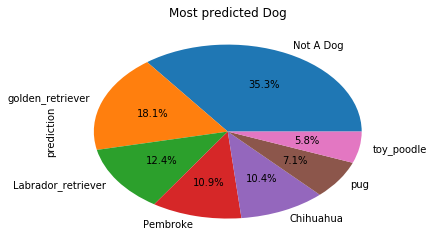

In [66]:
# Task 2:Storing, analyzing, and visualizing data Cell 2/5
#Visualizing data

#Question 1: What is the most predicted dog?
#Remove very rare dog types
Popular_Dogs = df['prediction'].value_counts()
Popular_Dogs[Popular_Dogs > 50].plot(kind='pie',autopct='%1.1f%%');
plt.title('Most predicted Dog')

Text(0.5,1,'Most Dog Type')

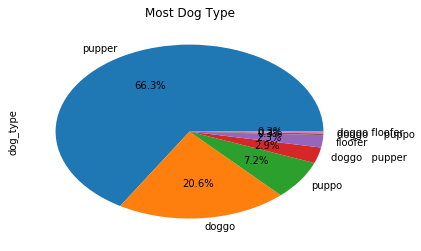

In [67]:
# Task 2:Storing, analyzing, and visualizing data Cell 3/5
#Visualizing data

#Question 2: What is the most common dog type?
df['dog_type'].value_counts()
Dogs_Types = df['dog_type'].value_counts()
Dogs_Types.drop('None').plot(kind='pie',autopct='%1.1f%%');
plt.title('Most Dog Type')

Text(0.5,1,'Dog Types Vs. mean Ratings')

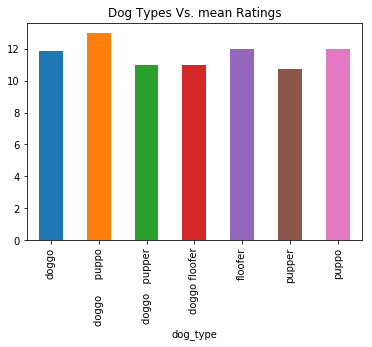

In [68]:
# Task 2:Storing, analyzing, and visualizing data Cell 4/5
#Visualizing data

#Question 3: which dog type has the highest average ratings?
mean_ratings = df.groupby('dog_type')['rating_numerator'].mean()
mean_ratings.drop('None').plot(kind='bar');
plt.title('Dog Types Vs. mean Ratings')

Text(0.5,1,'Dog Types Vs. max Ratings')

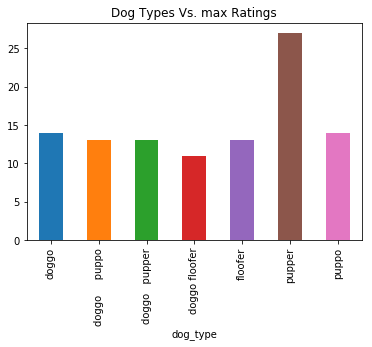

In [69]:
# Task 2:Storing, analyzing, and visualizing data Cell 5/5
#Visualizing data

#Question 4: which dog type has the highest maximim ratings?
max_ratings = df.groupby('dog_type')['rating_numerator'].max()
max_ratings.drop('None').plot(kind='bar');
plt.title('Dog Types Vs. max Ratings')